# Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load Data

In [ ]:
url = "https://docs.google.com/spreadsheets/d/1f4hMOhGJKEvzOiE3SLQ4uIu2-_t7hkjIqO-69x8IXQo/export?format=csv&gid=989197284"
df = pd.read_csv(url)

df.head()

,persentase_penduduk_miskin_tahun sebelumnya,id,kode_provinsi,nama_provinsi,jumlah_penduduk,persentase_penduduk_miskin,satuan,tahun,zakat terkumpul,penyaluran ke ekonomi,penyaluran ke fakir miskin
0,"14,45",457,11,ACEH,5409190,"14,64",PERSEN,2022,195571794390,10344660000,168784157892
1,"8,15",458,12,SUMATERA UTARA,15180530,"8,42",PERSEN,2022,54729903008,3775394000,35037502105
2,"5,95",459,13,SUMATERA BARAT,5677550,"5,92",PERSEN,2022,149165982067,14278701804,84869857700
3,"6,68",460,14,RIAU,6555746,"6,78",PERSEN,2022,137019643739,26906036991,87591751786
4,"7,58",461,15,JAMBI,3633190,"7,62",PERSEN,2022,52045387474,1260247550,31050446025


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 11 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   persentase_penduduk_miskin_tahun sebelumnya  102 non-null    object
 1   id                                           102 non-null    int64 
 2   kode_provinsi                                102 non-null    int64 
 3   nama_provinsi                                102 non-null    object
 4   jumlah_penduduk                              102 non-null    int64 
 5   persentase_penduduk_miskin                   102 non-null    object
 6   satuan                                       102 non-null    object
 7   tahun                                        102 non-null    int64 
 8   zakat terkumpul                              102 non-null    object
 9   penyaluran ke ekonomi                        102 non-null    int64 
 10  penyaluran ke 

# Data Preprocessing

## Data cleaning

In [ ]:
df = df.dropna()
df = df.loc[~(df == 0).any(axis=1)]
df = df.reset_index(drop=True)

In [ ]:
df['zakat terkumpul'] = (
    df['zakat terkumpul']
    .astype(str)
    .str.replace(r'[^\d]', '', regex=True)
    .astype(int)
)

In [ ]:
for col in ['persentase_penduduk_miskin', 'persentase_penduduk_miskin_tahun sebelumnya']:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '.', regex=False)
        .str.replace(r'[^\d\.]', '', regex=True)
        .astype(float)
    )

## Feature Enggineering

In [ ]:
df['tahun'].min()

2022

In [ ]:
df['tahun_num'] = df['tahun'] - df['tahun'].min()

In [ ]:
print(df.dtypes)

persentase_penduduk_miskin_tahun sebelumnya    float64
id                                               int64
kode_provinsi                                    int64
nama_provinsi                                   object
jumlah_penduduk                                  int64
persentase_penduduk_miskin                     float64
satuan                                          object
tahun                                            int64
zakat terkumpul                                  int64
penyaluran ke ekonomi                            int64
penyaluran ke fakir miskin                       int64
tahun_num                                        int64
dtype: object


## Cek korelasi

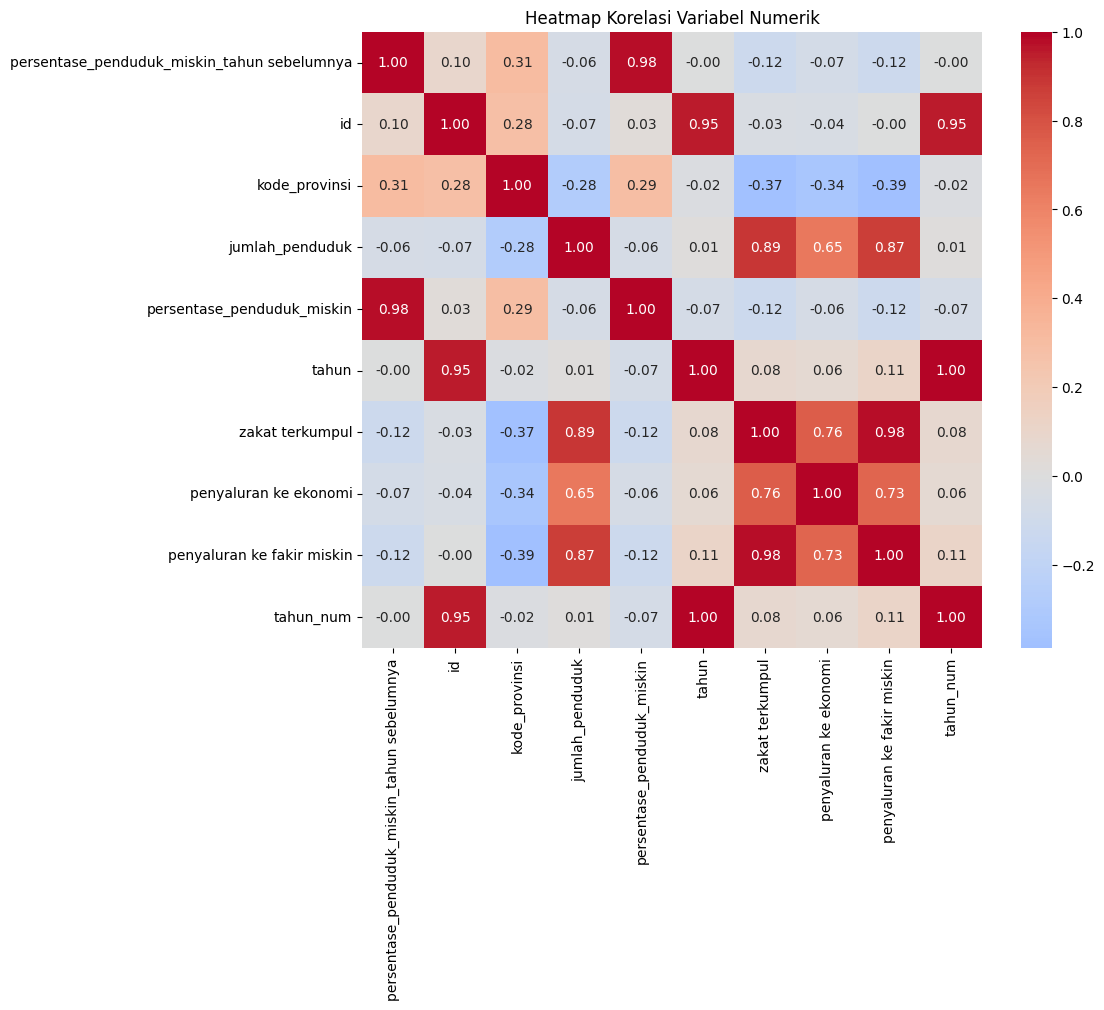

In [ ]:
df_numeric = df.select_dtypes(include=['number'])

corr = df_numeric.corr()

plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Heatmap Korelasi Variabel Numerik')
plt.show()

## Cek outlier

In [ ]:
outlier_info = {}
outlier_indices_per_column = {}

for col in df_numeric:

    # Hitung Q1, Q3, dan IQR
    data_sorted = df[col].dropna().sort_values().values
    n = len(data_sorted)

    # Hitung Q1 (kuartil pertama)
    q1_pos = (n + 1) * 0.25
    if q1_pos == int(q1_pos):
        q1 = data_sorted[int(q1_pos) - 1]
    else:
        lower = int(q1_pos) - 1
        upper = int(q1_pos)
        weight = q1_pos - int(q1_pos)
        q1 = data_sorted[lower] * (1 - weight) + data_sorted[upper] * weight

    # Hitung Q3 (kuartil ketiga)
    q3_pos = (n + 1) * 0.75
    if q3_pos == int(q3_pos):
        q3 = data_sorted[int(q3_pos) - 1]
    else:
        lower = int(q3_pos) - 1
        upper = int(q3_pos)
        weight = q3_pos - int(q3_pos)
        q3 = data_sorted[lower] * (1 - weight) + data_sorted[upper] * weight

    # Hitung IQR
    iqr = q3 - q1

    # Hitung batas outlier
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    # Identifikasi outlier
    outliers = []
    outlier_indices = []

    for i, value in enumerate(df[col]):
        if pd.notna(value):  # Skip NaN values
            if value < lower_bound or value > upper_bound:
                outliers.append(value)
                outlier_indices.append(i)

    outlier_info[col] = {
        'count': len(outliers),
        'values': outliers,
        'indices': outlier_indices,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound
    }

    outlier_indices_per_column[col] = set(outlier_indices)

    if len(outliers) > 0:
        print(f"Outlier Kolom: {col}: {len(outliers)}")

# Hitung baris yang mengandung outlier
rows_with_outliers = set()
for col, indices in outlier_indices_per_column.items():
    rows_with_outliers.update(indices)

rows_with_outliers = sorted(list(rows_with_outliers))

print(f"\nJumlah baris yang mengandung outlier: {len(rows_with_outliers)}")

Outlier Kolom: persentase_penduduk_miskin_tahun sebelumnya: 3
Outlier Kolom: jumlah_penduduk: 9
Outlier Kolom: persentase_penduduk_miskin: 3
Outlier Kolom: zakat terkumpul: 8
Outlier Kolom: penyaluran ke ekonomi: 11
Outlier Kolom: penyaluran ke fakir miskin: 10

Jumlah baris yang mengandung outlier: 20


In [ ]:
df_numeric.describe()

,persentase_penduduk_miskin_tahun sebelumnya,id,kode_provinsi,jumlah_penduduk,persentase_penduduk_miskin,tahun,zakat terkumpul,penyaluran ke ekonomi,penyaluran ke fakir miskin,tahun_num
count,99.000000,99.000000,99.000000,9.900000e+01,99.000000,99.000000,9.900000e+01,9.900000e+01,9.900000e+01,99.000000
mean,9.823737,511.202020,46.626263,8.365102e+06,9.639798,2023.000000,1.015403e+11,4.745386e+09,6.976917e+10,1.000000
std,4.890793,32.524396,25.880252,1.161302e+07,4.664769,0.820652,1.376613e+11,8.365461e+09,9.501695e+10,0.820652
min,4.250000,457.000000,11.000000,7.200600e+05,4.000000,2022.000000,4.606671e+08,8.500000e+06,5.506165e+08,0.000000
25%,6.200000,482.500000,19.000000,2.422025e+06,6.200000,2022.000000,1.463570e+10,2.814462e+08,9.546792e+09,0.000000
50%,8.150000,511.000000,51.000000,4.374310e+06,8.060000,2023.000000,4.455020e+10,1.247089e+09,2.972406e+10,1.000000
75%,11.840000,540.500000,71.500000,8.790410e+06,11.775000,2024.000000,1.374457e+11,5.081474e+09,8.697513e+10,2.000000
max,26.560000,567.000000,94.000000,5.034519e+07,26.560000,2024.000000,6.209476e+11,4.189422e+10,4.521726e+11,2.000000


## Cek distribusi

In [ ]:
skew_values = df_numeric.skew().sort_values(ascending=False)

# Tampilkan skewness
print(skew_values)

penyaluran ke ekonomi                          2.695722
jumlah_penduduk                                2.575858
zakat terkumpul                                2.056260
penyaluran ke fakir miskin                     2.014803
persentase_penduduk_miskin_tahun sebelumnya    1.363450
persentase_penduduk_miskin                     1.279289
kode_provinsi                                  0.071291
tahun                                          0.000000
tahun_num                                      0.000000
id                                            -0.001297
dtype: float64


# Modelling

prediktor: persentase_penduduk_miskin_tahun sebelumnya, zakat terkumpul, penyaluran ke ekonomi, penyaluran ke fakir miskin, tahun_num, kode_provinsi

target: persentase_penduduk_miskin

In [ ]:
# Target and features
X = df.drop(columns=["persentase_penduduk_miskin", "id", "nama_provinsi", "satuan", "jumlah_penduduk"])
y = df["persentase_penduduk_miskin"]

# ---- SPLIT DATA BERDASARKAN TAHUN ----
# Asumsikan kita pakai tahun terakhir sebagai test set
latest_year = df["tahun"].max()

X_train = X[X["tahun"] < latest_year].copy()
X_test = X[X["tahun"] == latest_year].copy()
y_train = y[X["tahun"] < latest_year].copy()
y_test = y[X["tahun"] == latest_year].copy()

# Drop kolom "tahun" setelah digunakan untuk split
X_train = X_train.drop(columns=["tahun"])
X_test = X_test.drop(columns=["tahun"])

# Fitur numerik dan fitur yang ingin di-transform dengan Yeo-Johnson
yeo_features = [
    "penyaluran ke ekonomi",
    "zakat terkumpul",
    "penyaluran ke fakir miskin",
    "persentase_penduduk_miskin_tahun sebelumnya"
]

# Sisanya tetap distandardisasi
standard_features = [col for col in X_train.columns if col not in yeo_features]

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ("yeo", PowerTransformer(method='yeo-johnson'), yeo_features),
    ("std", StandardScaler(), standard_features)
])

# Model candidates
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(random_state=42)
}

# Evaluasi model
model_results = {}
metrics = {}

for name, model in models.items():
    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", model)
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    model_results[name] = {
        "y_true": y_test,
        "y_pred": y_pred
    }

    metrics[name] = {"RMSE": rmse, "MAE": mae, "R2": r2}

# Tampilkan hasil evaluasi
metrics

{'Linear Regression': {'RMSE': np.float64(1.5356583607638008),
  'MAE': 1.1519016692063553,
  'R2': 0.8551686013192726},
 'Ridge Regression': {'RMSE': np.float64(1.3710480284109303),
  'MAE': 1.0320733247940062,
  'R2': 0.884554012001844},
 'Random Forest': {'RMSE': np.float64(1.2435423756350237),
  'MAE': 0.5769212121212112,
  'R2': 0.9050281963623542}}

In [ ]:
def plot_predictions(y_true, y_pred, model_name):
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
    plt.xlabel("Aktual")
    plt.ylabel("Prediksi")
    plt.title(f"Prediksi vs Aktual - {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, kde=True, bins=20)
    plt.title(f"Distribusi Residual - {model_name}")
    plt.xlabel("Residual")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals_scatter(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Prediksi")
    plt.ylabel("Residual")
    plt.title(f"Residual vs Prediksi - {model_name}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

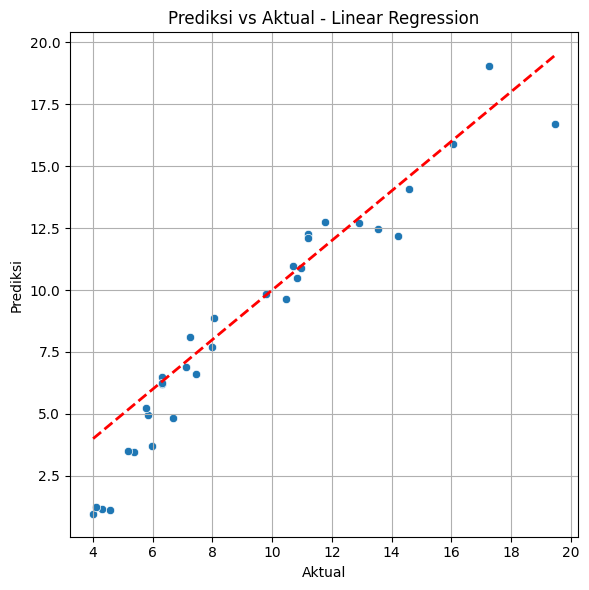

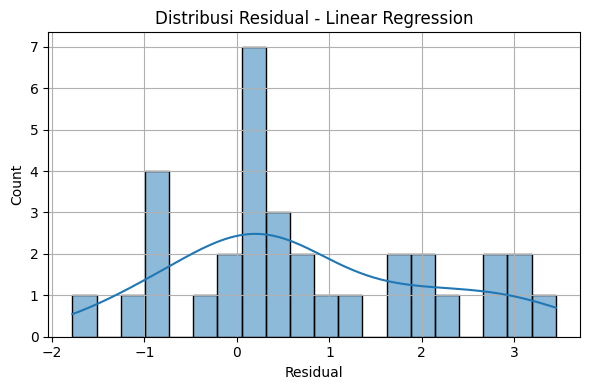

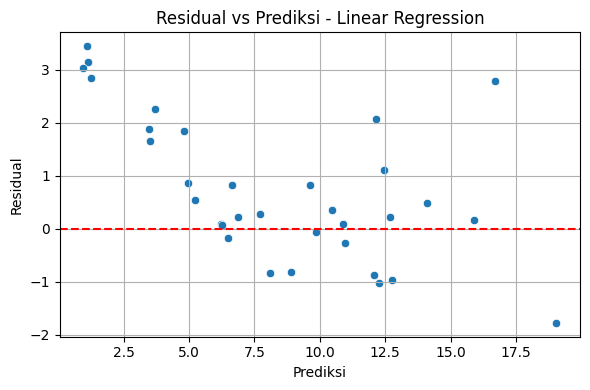

In [ ]:
name = "Linear Regression"
y_true = model_results[name]["y_true"]
y_pred = model_results[name]["y_pred"]

plot_predictions(y_true, y_pred, name)
plot_residuals(y_true, y_pred, name)
plot_residuals_scatter(y_true, y_pred, name)

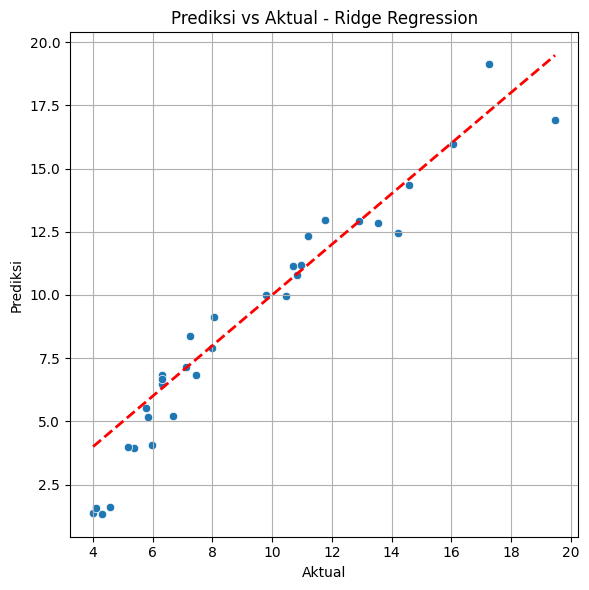

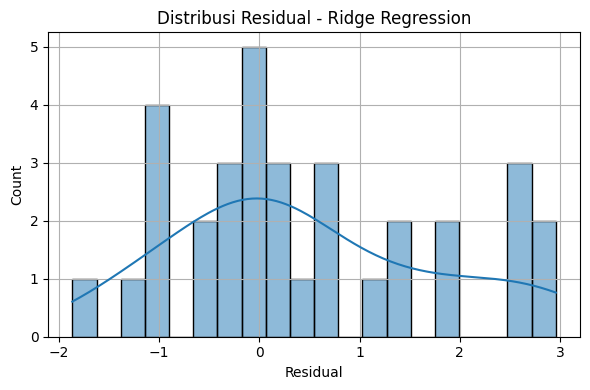

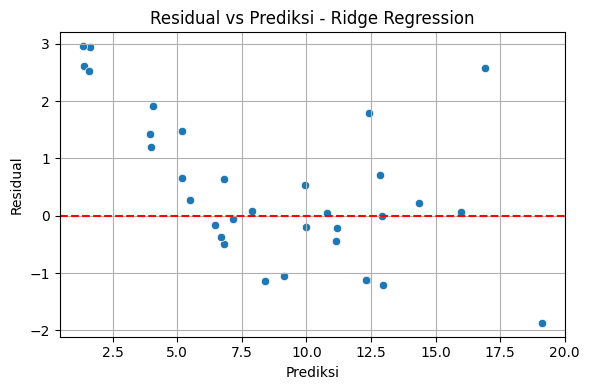

In [ ]:
name = "Ridge Regression"
y_true = model_results[name]["y_true"]
y_pred = model_results[name]["y_pred"]

plot_predictions(y_true, y_pred, name)
plot_residuals(y_true, y_pred, name)
plot_residuals_scatter(y_true, y_pred, name)

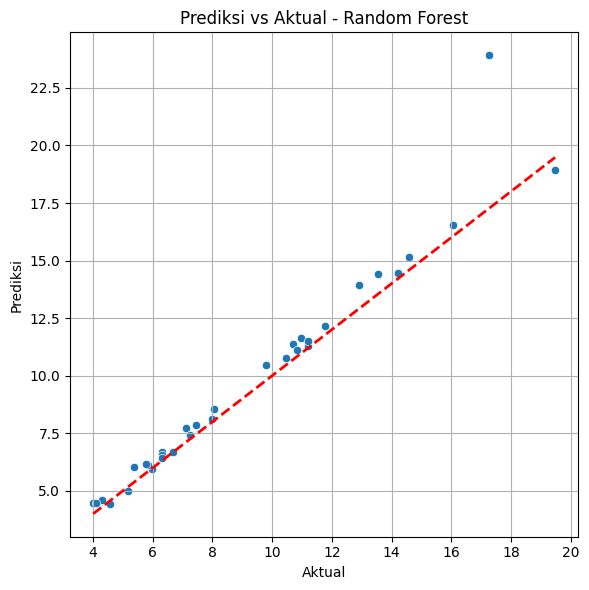

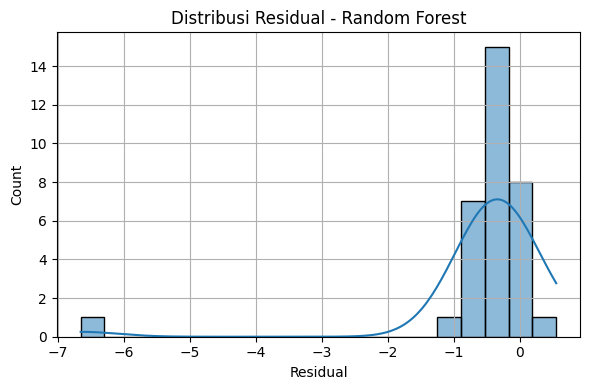

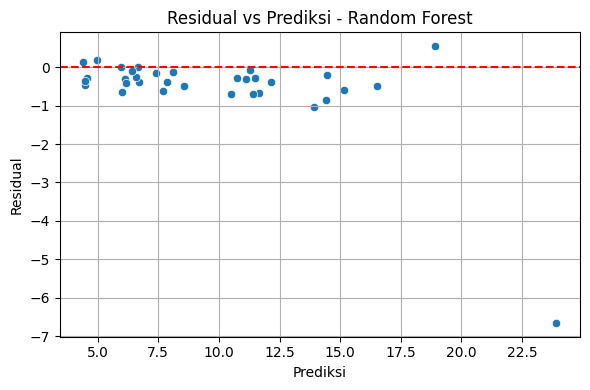

In [ ]:
name = "Random Forest"
y_true = model_results[name]["y_true"]
y_pred = model_results[name]["y_pred"]

plot_predictions(y_true, y_pred, name)
plot_residuals(y_true, y_pred, name)
plot_residuals_scatter(y_true, y_pred, name)

## Save Model

In [ ]:
import joblib
import pandas as pd

# Pilih model Random Forest
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", models["Random Forest"])
])
rf_pipeline.fit(X_train, y_train)

# Buat dictionary untuk semua komponen
model_bundle = {
    'model': rf_pipeline,
    'tahun_min': df['tahun'].min(),
    'province_mapping': df.drop_duplicates(subset=['id', 'nama_provinsi'])
                      .set_index('nama_provinsi')['id']
                      .to_dict(),
    'feature_columns': X_train.columns.tolist()
}

# Simpan semua komponen dalam satu file
joblib.dump(model_bundle, 'poverty_prediction_model.joblib')

## Predict kemiskinan
### Data kemiskinana tahun lalu diisi manual

In [ ]:
import joblib
import pandas as pd

# Load model bundle
bundle = joblib.load('poverty_prediction_model.joblib')
model = bundle['model']
tahun_min = bundle['tahun_min']
province_mapping = bundle['province_mapping']
feature_columns = bundle['feature_columns']

def preprocess_input(input_user, province_mapping, tahun_min, feature_columns):
    kode_provinsi = province_mapping[input_user['nama_provinsi']]
    tahun_num = input_user['tahun'] - tahun_min

    total_zakat = input_user['zakat terkumpul']

    # Konversi proporsi persen ke nominal
    if 'penyaluran ke ekonomi' not in input_user and 'penyaluran ke ekonomi %' in input_user:
        input_user['penyaluran ke ekonomi'] = total_zakat * (input_user['penyaluran ke ekonomi %'] / 100)

    if 'penyaluran ke fakir miskin' not in input_user and 'penyaluran ke fakir miskin %' in input_user:
        input_user['penyaluran ke fakir miskin'] = total_zakat * (input_user['penyaluran ke fakir miskin %'] / 100)


    input_data = {}
    for col in feature_columns:
        if col == 'id':
            input_data[col] = kode_provinsi
        elif col == 'tahun_num':
            input_data[col] = tahun_num
        else:
            input_data[col] = input_user[col]

    input_df = pd.DataFrame([input_data], columns=feature_columns)
    return input_df

def main():
  # Contoh input user
  input_user = {
      "nama_provinsi": "Jawa Barat",
      "tahun": 2025,
      "zakat terkumpul": 2.5e9,
      "penyaluran ke ekonomi %": 30,
      "penyaluran ke fakir miskin %": 20,
      # "penyaluran ke ekonomi": 1.2e9,
      # "penyaluran ke fakir miskin": 8e8,
      "persentase_penduduk_miskin_tahun sebelumnya": 8.5,
  }

  input_df = preprocess_input(input_user, province_mapping, tahun_min, feature_columns)
  prediction = model.predict(input_df)[0]

  print(f"Prediksi persentase penduduk miskin: {prediction:.2f}%")

if __name__ == "__main__":
    main()

### Data kemiskinan tahun lalu diambil dari API BPS

In [ ]:
import requests
import joblib
import pandas as pd

API_KEY = "142c3da864f63cd8bfc6d5572caf0053"
BASE_URL_TEMPLATE = (
    "https://webapi.bps.go.id/v1/api/list/model/data"
    "/lang/ind"
    "/domain/0000"
    "/var/192"
    "/turvar/434"
    "/turtahun/61"
    "/th/{tahun_code}"
    f"/key/{API_KEY}"
)

def tahun_to_code(tahun):
    return str(tahun - 1900)

def fetch_data(tahun_code):
    url = BASE_URL_TEMPLATE.format(tahun_code=tahun_code)
    resp = requests.get(url)
    print("Status:", resp.status_code)
    if resp.status_code != 200:
        raise Exception(f"Gagal fetch data BPS: {resp.text}")
    return resp.json()

def build_province_map(vervar_list):
    return {item['label'].strip().upper(): str(item['val']) for item in vervar_list}

def get_miskin_last_year(province_name, tahun):
    tahun_sebelumnya_code = tahun_to_code(tahun - 1)
    data = fetch_data(tahun_sebelumnya_code)

    vervar = data.get("vervar", [])
    datacontent = data.get("datacontent", {})

    prov_map = build_province_map(vervar)
    prov_name_upper = province_name.strip().upper()

    if prov_name_upper not in prov_map:
        raise ValueError(f"Provinsi '{province_name}' tidak ditemukan.")

    prov_code = prov_map[prov_name_upper]
    target_suffix = "2461"

    for key, val in datacontent.items():
        if key.startswith(prov_code) and key.endswith(target_suffix):
            return val

    raise ValueError(f"Tidak ditemukan data untuk {province_name} tahun {tahun - 1}")

Status: 200
Persentase penduduk miskin di JAWA BARAT (Semester 1, 2024): 7.46%


In [ ]:
# Load model
bundle = joblib.load('poverty_prediction_model.joblib')
model = bundle['model']
tahun_min = bundle['tahun_min']
province_mapping = bundle['province_mapping']
feature_columns = bundle['feature_columns']

def preprocess_input(input_user, province_mapping, tahun_min, feature_columns):
    kode_provinsi = province_mapping[input_user['nama_provinsi']]
    tahun_num = input_user['tahun'] - tahun_min

    total_zakat = input_user['zakat terkumpul']

    # Konversi proporsi persen ke nominal
    if 'penyaluran ke ekonomi' not in input_user and 'penyaluran ke ekonomi %' in input_user:
        input_user['penyaluran ke ekonomi'] = total_zakat * (input_user['penyaluran ke ekonomi %'] / 100)

    if 'penyaluran ke fakir miskin' not in input_user and 'penyaluran ke fakir miskin %' in input_user:
        input_user['penyaluran ke fakir miskin'] = total_zakat * (input_user['penyaluran ke fakir miskin %'] / 100)


    input_data = {}
    for col in feature_columns:
        if col == 'id':
            input_data[col] = kode_provinsi
        elif col == 'tahun_num':
            input_data[col] = tahun_num
        else:
            input_data[col] = input_user[col]

    return pd.DataFrame([input_data], columns=feature_columns)

def main():
    # Input dari user
    input_user = {
        "nama_provinsi": "Jawa Barat",
        "tahun": 2025,
        "zakat terkumpul": 2.5e9,
        "penyaluran ke ekonomi %": 30,
        "penyaluran ke fakir miskin %": 20,
        # "penyaluran ke ekonomi": 1.2e9,
        # "penyaluran ke fakir miskin": 8e8,
    }

    # Ambil data dari API (atau sumber lain)
    persen_miskin_last_year = get_miskin_last_year(
        input_user["nama_provinsi"],
        input_user["tahun"]
    )
    input_user["persentase_penduduk_miskin_tahun sebelumnya"] = persen_miskin_last_year

    # Siapkan input dan prediksi
    input_df = preprocess_input(input_user, province_mapping, tahun_min, feature_columns)
    prediction = model.predict(input_df)[0]

    print(f"Prediksi persentase penduduk miskin tahun {input_user['tahun']} "
          f"(di {input_user['nama_provinsi']}): {prediction:.2f}%")

if __name__ == "__main__":
    main()